<a href="https://colab.research.google.com/github/AnKiTu03/Ludwig/blob/main/Intent_Classification_with_LLM_Fine_Tuning_on_Support_Call_Transcripts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Intent Classification with LLM: Fine-Tuning on Support Call Transcripts using Ludwig***

---



---



---




### ***In this project, Our team has fine-tuned the Hugging Face Mistral-7B language model for support call transcripts. The goal was to enhance the model's ability to classify intent based on the content of the transcript. This enables automated and accurate categorization of customer support inquiries, streamlining response workflows for more effective customer service.***

---



## Ludwig Installation for Language Model (LLM)

In this notebook, I'm using Ludwig to set up a Language Model (LLM) for text classification tasks. To achieve this, I'm installing Ludwig and its additional components for language model training.


---



In [ ]:
!pip uninstall -y tensorflow --quiet
!pip install ludwig --quiet
!pip install ludwig[llm] --quiet
!pip install torch
!pip install ptitprince

## Environment Setup

In this section, the code sets up the necessary environment for a Colab notebook:

- Imports key libraries and modules.
- Configures the preferred encoding to UTF-8.
- Retrieves the Hugging Face Hub token from Colab user data and sets it in the environment variable.



---



In [ ]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import yaml

from ludwig.api import LudwigModel


## Dataset Setup for Model Training

- Loads data from "Ludwig.csv."
- Creates a 'split' column for train, validation, and test sets.
- Shuffles and assigns rows randomly.


---



In [ ]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/AnKiTu03/Ludwig/main/Ludwig.csv")
df.drop('Intent and Urgency', inplace=True, axis=1)

# We're going to create a new column called `split` where:
# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set
# Calculate the number of rows for each split value
total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
df['split'] = split_values
df['split'] = df['split'].astype(int)

df = df.head(1000)

## **Understanding the Dataset** 📖

---






In [ ]:
df.head(10)

,ID,Transcript,Intent,Urgency,split
0,1,My internet is down and I've tried rebooting m...,Technical Issue,High,0
1,2,I'm calling to inquire about the charges on my...,Billing Inquiry,Low,0
2,3,I've been experiencing intermittent connectivi...,Technical Issue,Medium,1
3,4,I'd like to upgrade my current plan to include...,Service Upgrade,Low,0
4,5,I think I've received a faulty device from you...,Product Issue,High,0
5,6,I'm moving to a new house and need to transfer...,Service Transfer,Medium,2
6,7,I was overcharged this month and I need a refu...,Billing Issue,High,0
7,8,I'm considering canceling my service. Can you ...,Cancellation,Low,0
8,9,"My phone line is crackling, and I can barely h...",Technical Issue,Medium,0
9,10,I'm not sure how to set up my voicemail. Can y...,Setup Assistance,Low,0


## Token Distribution Analysis

This code assesses the distribution of tokens using the 'mistralai/Mistral-7B-v0.1' tokenizer:

- Counts tokens in 'Transcript,' 'Intent,' and 'Urgency.'
- Computes key statistics: average, min, max, median.

The resulting DataFrame, 'token_distribution,' offers valuable insights into the token distribution across different columns.


---



---



In [ ]:
from transformers import AutoTokenizer
import numpy as np
import pandas as pd

def calculate_distribution(data_dict):
    result = {}

    for key, values in data_dict.items():
        values = np.array(values)
        result[key] = {
            'average': int(np.mean(values)),
            'min': np.min(values),
            'max': np.max(values),
            'median': np.median(values),
        }

    return result

tokenizer = AutoTokenizer.from_pretrained('mistralai/Mistral-7B-v0.1')

token_counts = {
    "Transcript": [],
    "Urgency": [],
    "Intent": [],
}

for index, row in df.iterrows():
    # Tokenize the 'transcript' column for input
    input_col_tokens = len(tokenizer.tokenize(row['Transcript']))

    # Tokenize the 'intent' and 'urgency' columns for output
    intent_col_tokens = len(tokenizer.tokenize(row['Intent']))
    urgency_col_tokens = len(tokenizer.tokenize(row['Urgency']))

    token_counts['Transcript'].append(input_col_tokens)
    token_counts['Intent'].append(intent_col_tokens)
    token_counts['Urgency'].append(urgency_col_tokens)

token_distribution = calculate_distribution(token_counts)
token_distribution = pd.DataFrame(token_distribution)
token_distribution


tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

,Transcript,Urgency,Intent
average,18.0,1.0,2.0
min,10.0,1.0,2.0
max,52.0,2.0,6.0
median,19.0,1.0,3.0




---



---


## Model Fine-Tuning Configuration

Fine-tuning a Language Model (LLM) using Ludwig:

- **Base Model:** 'mistralai/Mistral-7B-v0.1'
- **Input:** Transcript
- **Output:** Intent
- **Prompt Template:** Transcript-based response

#### Generation
- Temp: 0.1, Max Tokens: 512

#### Adapter & Quantization
- Adapter: LORA, Quantization: 4 bits

#### Preprocessing & Splitting
- Max Seq Length: 512, Random Split: 90% train, 5% val, 5% test

#### Training
- Epochs: 3, Batch Size: 2, Eval Batch Size: 2
- Grad Accum Steps: 16, LR: 0.0005, Warmup: 0.03


---



---



In [ ]:
import logging
import yaml
from ludwig.api import LudwigModel

qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model:  alexsherstinsky/Mistral-7B-v0.1-sharded

input_features:
  - name: Transcript
    type: text

output_features:
  - name: Intent
    type: text

prompt:
  template: >-


    ### Transcript: {Transcript}

    ### Response:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 0.9 # train
    - 0.05 # val
    - 0.05 # test

trainer:
  type: finetune
  epochs: 3
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.0004
  learning_rate_scheduler:
    warmup_fraction: 0.03
""")

# Create a Ludwig model using the configuration
model1 = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)

# Train the model with your dataset
results = model1.train(dataset=df)

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

tokenizer_config.json:   0%|          | 0.00/979 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/145 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of alexsherstinsky/Mistral-7B-v0.1-sharded tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'None': 63 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 65 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 65 for feature 'None'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of alexsherstinsky/Mistral-7B-v0.1-sharded tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'Intent': 5 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 7 (including start and stop symb

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

INFO:ludwig.models.llm:Done.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of alexsherstinsky/Mistral-7B-v0.1-sharded tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.04703666202518836


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 771 step(s), approximately 3 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 1285 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training:  33%|███▎      | 257/771 [02:01<04:06,  2.09it/s, loss=0.058]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 257, epoch: 0


Evaluation test : 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4.1005s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     5.2103 │       5.8326 │     5.1471 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     4.6657 │       0.6878 │     0.8232 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 22773.6133 │   15761.1104 │ 15939.1484 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31647.8887 │   31923.4336 │ 31941.4023 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.095


Training:  67%|██████▋   | 514/771 [04:07<02:02,  2.09it/s, loss=0.154]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 514, epoch: 1


Evaluation test : 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

INFO:ludwig.trainers.trainer:Evaluation took 3.9761s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     5.3308 │       5.4758 │     4.9454 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.5005 │       0.4686 │     0.2748 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 14580.9346 │   14322.0342 │ 13721.5850 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31987.4629 │   32000.4902 │ 32000.2148 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.171


Training: 100%|██████████| 771/771 [06:14<00:00,  2.08it/s, loss=0.000532]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 771, epoch: 2


Evaluation test : 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4.4840s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     4.8822 │       5.9251 │     5.3151 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.1695 │       0.3967 │     0.1816 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 12948.4141 │   13575.6318 │ 13060.4004 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 32001.4980 │   31998.0176 │ 31998.6602 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.197


Training: 100%|██████████| 771/771 [06:19<00:00,  2.03it/s, loss=0.000532]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════╤═════════════════════╕
│ Validation feature           │ Intent              │
├──────────────────────────────┼─────────────────────┤
│ Validation metric            │ loss                │
├──────────────────────────────┼─────────────────────┤
│ Best model step              │ 771                 │
├──────────────────────────────┼─────────────────────┤
│ Best model epoch             │ 3                   │
├──────────────────────────────┼─────────────────────┤
│ Best model's validation loss │ 0.39671558141708374 │
├──────────────────────────────┼─────────────────────┤
│ Best model's test loss       │ 0.18157421052455902 │
╘══════════════════════════════╧═════════════════════╛
INFO:ludwig.api:
Finished: api_experiment_run
INFO:ludwig

INFO:ludwig.utils.print_utils:


# **Testing the model on user inputs**

---




In [ ]:
# Get user input for the transcript
transcript_input = input("Enter the transcript: ")

# Create a DataFrame with the user input
test_examples = pd.DataFrame([{"Transcript": transcript_input}])

# Make predictions
predictions = model1.predict(test_examples, generation_config={'temperature': 0.1, 'max_new_tokens': 128})[0]



Enter the transcript: I need a receipt for my recent payment. Where can I find it online?


INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of alexsherstinsky/Mistral-7B-v0.1-sharded tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: 

### transcript: i need a receipt for my recent payment. where can i find it online?
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: 

### transcript: i need a receipt for my recent payment. where can i find it online?
### response: billing inquiry


Prediction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of alexsherstinsky/Mistral-7B-v0.1-sharded tokenizer


/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [ ]:
for input_with_prediction in zip(test_examples['Transcript'], predictions['Intent_response'],):
    print(f"Transcript: {input_with_prediction[0]}")
    print(f"Generated Intent: {input_with_prediction[1][0]}")
    print("\n\n")

Transcript: I need a receipt for my recent payment. Where can I find it online?
Generated Intent: billing inquiry








---

---




---


# **Training the dataset on the ludwig-based model for the urgency category.**


---


---


---





# Model Features

Input Feature:

    Name: Transcript

    Type: Text

    Preprocessing: Num Channels - 3

Output Feature:

    Name: Urgency

    Type: Category

Training Parameters:

    Epochs: 10

    Batch Size: 2

    Learning Rate: 0.0005


In [ ]:
import logging
from ludwig.api import LudwigModel

config = {
  "input_features": [
    {
      "name": "Transcript",
      "type": "text",
      "preprocessing": {
        "num_channels": 3
      }
    }
  ],
  "output_features": [
     {
      "name" : "Urgency",
      "type" : "category"
    }
  ],
  "training": {
    "epochs": 10,
    "batch_size": 2,
    "learning_rate": 0.0005,
    }

    }


model = LudwigModel(config, logging_level=logging.INFO)
train_stats, preprocessed_data, output_directory = model.train(dataset=df)


INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run_0                                                   │
├──────────────────┼─────────────────────────────────────────────────────────────────

Training:  10%|▉         | 99/1000 [00:02<00:15, 57.94it/s, loss=0.754]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 100, epoch: 0


Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 99.62it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7290s

INFO:ludwig.utils.metrics_printed_table:╒════════════════╤═════════╤══════════════╤════════╕
│                │   train │   validation │   test │
╞════════════════╪═════════╪══════════════╪════════╡
│ accuracy       │  0.4201 │       0.6250 │ 0.6201 │
├────────────────┼─────────┼──────────────┼────────┤
│ accuracy_micro │  0.4550 │       0.7143 │ 0.6316 │
├────────────────┼─────────┼──────────────┼────────┤
│ loss           │  1.3340 │       0.6468 │ 0.8543 │
├────────────────┼─────────┼──────────────┼────────┤
│ roc_auc        │  0.6177 │       0.9247 │ 0.8532 │
├────────────────┼─────────┼──────────────┼────────┤
│ combined_loss  │  1.3340 │       0.6468 │ 0.8543 │
╘════════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'Urgency' 'accuracy' improved.
INFO:ludwig.trainers.trainer:'Urgency' 'accuracy' increased by inf.
INFO:ludwig.trainers.trainer:New best model saved.




Training:  20%|█▉        | 199/1000 [00:04<00:12, 62.53it/s, loss=0.00334]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 200, epoch: 1


Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 171.04it/s]


INFO:ludwig.trainers.trainer:Evaluation took 0.5608s

INFO:ludwig.utils.metrics_printed_table:╒════════════════╤═════════╤══════════════╤════════╕
│                │   train │   validation │   test │
╞════════════════╪═════════╪══════════════╪════════╡
│ accuracy       │  0.6717 │       0.6806 │ 0.6365 │
├────────────────┼─────────┼──────────────┼────────┤
│ accuracy_micro │  0.7000 │       0.7500 │ 0.6491 │
├────────────────┼─────────┼──────────────┼────────┤
│ loss           │  0.9227 │       0.7277 │ 1.0022 │
├────────────────┼─────────┼──────────────┼────────┤
│ roc_auc        │  0.8522 │       0.9121 │ 0.8242 │
├────────────────┼─────────┼──────────────┼────────┤
│ combined_loss  │  0.9227 │       0.7277 │ 1.0022 │
╘════════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'Urgency' 'accuracy' improved.
INFO:ludwig.trainers.trainer:'Urgency' 'accuracy' increased by 0.056.
INFO:ludwig.trainers.trainer:New best model saved.



Training:  30%|██▉       | 299/1000 [00:06<00:10, 64.88it/s, loss=0.411]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 300, epoch: 2


Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 176.21it/s]


INFO:ludwig.trainers.trainer:Evaluation took 0.5444s

INFO:ludwig.utils.metrics_printed_table:╒════════════════╤═════════╤══════════════╤════════╕
│                │   train │   validation │   test │
╞════════════════╪═════════╪══════════════╪════════╡
│ accuracy       │  0.8449 │       0.6597 │ 0.7236 │
├────────────────┼─────────┼──────────────┼────────┤
│ accuracy_micro │  0.8600 │       0.7143 │ 0.7368 │
├────────────────┼─────────┼──────────────┼────────┤
│ loss           │  0.6447 │       2.1076 │ 1.5232 │
├────────────────┼─────────┼──────────────┼────────┤
│ roc_auc        │  0.9511 │       0.8591 │ 0.8600 │
├────────────────┼─────────┼──────────────┼────────┤
│ combined_loss  │  0.6447 │       2.1076 │ 1.5232 │
╘════════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of Urgency validation accuracy happened 100 step(s) ago.



Training:  40%|████      | 400/1000 [00:07<00:09, 63.99it/s, loss=0.0226]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 400, epoch: 3


Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 153.72it/s]


INFO:ludwig.trainers.trainer:Evaluation took 0.5878s

INFO:ludwig.utils.metrics_printed_table:╒════════════════╤═════════╤══════════════╤════════╕
│                │   train │   validation │   test │
╞════════════════╪═════════╪══════════════╪════════╡
│ accuracy       │  0.9163 │       0.7361 │ 0.6888 │
├────────────────┼─────────┼──────────────┼────────┤
│ accuracy_micro │  0.9250 │       0.7857 │ 0.7018 │
├────────────────┼─────────┼──────────────┼────────┤
│ loss           │  0.2932 │       1.7078 │ 1.8381 │
├────────────────┼─────────┼──────────────┼────────┤
│ roc_auc        │  0.9871 │       0.9029 │ 0.8569 │
├────────────────┼─────────┼──────────────┼────────┤
│ combined_loss  │  0.2932 │       1.7078 │ 1.8381 │
╘════════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'Urgency' 'accuracy' improved.
INFO:ludwig.trainers.trainer:'Urgency' 'accuracy' increased by 0.056.
INFO:ludwig.trainers.trainer:New best model saved.



Training:  50%|████▉     | 499/1000 [00:09<00:07, 65.07it/s, loss=0.00032] 

INFO:ludwig.trainers.trainer:
Running evaluation for step: 500, epoch: 4


Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 140.89it/s]


INFO:ludwig.trainers.trainer:Evaluation took 0.5378s

INFO:ludwig.utils.metrics_printed_table:╒════════════════╤═════════╤══════════════╤════════╕
│                │   train │   validation │   test │
╞════════════════╪═════════╪══════════════╪════════╡
│ accuracy       │  0.9440 │       0.7917 │ 0.7246 │
├────────────────┼─────────┼──────────────┼────────┤
│ accuracy_micro │  0.9500 │       0.8214 │ 0.7368 │
├────────────────┼─────────┼──────────────┼────────┤
│ loss           │  0.1854 │       1.3536 │ 2.1704 │
├────────────────┼─────────┼──────────────┼────────┤
│ roc_auc        │  0.9962 │       0.9129 │ 0.8546 │
├────────────────┼─────────┼──────────────┼────────┤
│ combined_loss  │  0.1854 │       1.3536 │ 2.1704 │
╘════════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'Urgency' 'accuracy' improved.
INFO:ludwig.trainers.trainer:'Urgency' 'accuracy' increased by 0.056.
INFO:ludwig.trainers.trainer:New best model saved.



Training:  60%|█████▉    | 599/1000 [00:11<00:06, 64.53it/s, loss=2.38e-7]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 600, epoch: 5


Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 159.86it/s]


INFO:ludwig.trainers.trainer:Evaluation took 0.6103s

INFO:ludwig.utils.metrics_printed_table:╒════════════════╤═════════╤══════════════╤════════╕
│                │   train │   validation │   test │
╞════════════════╪═════════╪══════════════╪════════╡
│ accuracy       │  0.9879 │       0.7569 │ 0.6865 │
├────────────────┼─────────┼──────────────┼────────┤
│ accuracy_micro │  0.9900 │       0.8214 │ 0.7018 │
├────────────────┼─────────┼──────────────┼────────┤
│ loss           │  0.0575 │       1.6909 │ 2.6072 │
├────────────────┼─────────┼──────────────┼────────┤
│ roc_auc        │  0.9987 │       0.9238 │ 0.8604 │
├────────────────┼─────────┼──────────────┼────────┤
│ combined_loss  │  0.0575 │       1.6909 │ 2.6072 │
╘════════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of Urgency validation accuracy happened 100 step(s) ago.



Training:  70%|██████▉   | 699/1000 [00:13<00:04, 67.44it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 700, epoch: 6


Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 180.81it/s]


INFO:ludwig.trainers.trainer:Evaluation took 0.5374s

INFO:ludwig.utils.metrics_printed_table:╒════════════════╤═════════╤══════════════╤════════╕
│                │   train │   validation │   test │
╞════════════════╪═════════╪══════════════╪════════╡
│ accuracy       │  0.9939 │       0.7569 │ 0.6831 │
├────────────────┼─────────┼──────────────┼────────┤
│ accuracy_micro │  0.9950 │       0.8214 │ 0.7018 │
├────────────────┼─────────┼──────────────┼────────┤
│ loss           │  0.0108 │       2.1041 │ 2.8325 │
├────────────────┼─────────┼──────────────┼────────┤
│ roc_auc        │  1.0000 │       0.9280 │ 0.8694 │
├────────────────┼─────────┼──────────────┼────────┤
│ combined_loss  │  0.0108 │       2.1041 │ 2.8325 │
╘════════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of Urgency validation accuracy happened 200 step(s) ago.



Training:  80%|███████▉  | 799/1000 [00:15<00:03, 52.21it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 800, epoch: 7


Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 155.25it/s]


INFO:ludwig.trainers.trainer:Evaluation took 0.6854s

INFO:ludwig.utils.metrics_printed_table:╒════════════════╤═════════╤══════════════╤════════╕
│                │   train │   validation │   test │
╞════════════════╪═════════╪══════════════╪════════╡
│ accuracy       │  0.9939 │       0.7361 │ 0.6691 │
├────────────────┼─────────┼──────────────┼────────┤
│ accuracy_micro │  0.9950 │       0.7857 │ 0.6842 │
├────────────────┼─────────┼──────────────┼────────┤
│ loss           │  0.0321 │       2.8345 │ 2.7396 │
├────────────────┼─────────┼──────────────┼────────┤
│ roc_auc        │  1.0000 │       0.9003 │ 0.8640 │
├────────────────┼─────────┼──────────────┼────────┤
│ combined_loss  │  0.0321 │       2.8345 │ 2.7396 │
╘════════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of Urgency validation accuracy happened 300 step(s) ago.



Training:  90%|████████▉ | 899/1000 [00:17<00:01, 53.89it/s, loss=5.96e-8]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 900, epoch: 8


Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 135.99it/s]


INFO:ludwig.trainers.trainer:Evaluation took 0.6099s

INFO:ludwig.utils.metrics_printed_table:╒════════════════╤═════════╤══════════════╤════════╕
│                │   train │   validation │   test │
╞════════════════╪═════════╪══════════════╪════════╡
│ accuracy       │  0.9939 │       0.7569 │ 0.6865 │
├────────────────┼─────────┼──────────────┼────────┤
│ accuracy_micro │  0.9950 │       0.8214 │ 0.7018 │
├────────────────┼─────────┼──────────────┼────────┤
│ loss           │  0.0211 │       2.2420 │ 2.9418 │
├────────────────┼─────────┼──────────────┼────────┤
│ roc_auc        │  0.9999 │       0.9263 │ 0.8757 │
├────────────────┼─────────┼──────────────┼────────┤
│ combined_loss  │  0.0211 │       2.2420 │ 2.9418 │
╘════════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of Urgency validation accuracy happened 400 step(s) ago.



Training: 100%|█████████▉| 999/1000 [00:19<00:00, 64.00it/s, loss=0]      

INFO:ludwig.trainers.trainer:
Running evaluation for step: 1000, epoch: 9


Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 177.74it/s]


INFO:ludwig.trainers.trainer:Evaluation took 0.6433s

INFO:ludwig.utils.metrics_printed_table:╒════════════════╤═════════╤══════════════╤════════╕
│                │   train │   validation │   test │
╞════════════════╪═════════╪══════════════╪════════╡
│ accuracy       │  1.0000 │       0.7361 │ 0.6898 │
├────────────────┼─────────┼──────────────┼────────┤
│ accuracy_micro │  1.0000 │       0.7857 │ 0.7018 │
├────────────────┼─────────┼──────────────┼────────┤
│ loss           │  0.0000 │       2.6138 │ 3.2774 │
├────────────────┼─────────┼──────────────┼────────┤
│ roc_auc        │  1.0000 │       0.9115 │ 0.8606 │
├────────────────┼─────────┼──────────────┼────────┤
│ combined_loss  │  0.0000 │       2.6138 │ 3.2774 │
╘════════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of Urgency validation accuracy happened 500 step(s) ago.

INFO:ludwig.trainers.trainer:
EARLY STOPPING due to lack of validation improvement. It has been 500 step(s) since

Training: 100%|██████████| 1000/1000 [00:19<00:00, 51.13it/s, loss=0]


INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════════╤════════════════════╕
│ Validation feature               │ Urgency            │
├──────────────────────────────────┼────────────────────┤
│ Validation metric                │ accuracy           │
├──────────────────────────────────┼────────────────────┤
│ Best model step                  │ 500                │
├──────────────────────────────────┼────────────────────┤
│ Best model epoch                 │ 5                  │
├──────────────────────────────────┼────────────────────┤
│ Best model's validation accuracy │ 0.7916666269302368 │
├──────────────────────────────────┼────────────────────┤
│ Best model's test accuracy       │ 0.7245990037918091 │
╘══════════════════════════════════╧════════════════════╛
INFO:ludwig.api:
F



---
# **Testing the model on user input**

---




In [ ]:
predictions = model.predict(test_examples)
predictions[0]

Prediction: 100%|██████████| 1/1 [00:00<00:00, 339.43it/s]


,Urgency_predictions,Urgency_probabilities,Urgency_probability,Urgency_probabilities_Low,Urgency_probabilities_Medium,Urgency_probabilities_High
0,Low,"[0.9999324083328247, 2.3851731384638697e-05, 4...",0.999932,0.999932,0.000024,0.000044


# Testing the model on the whole data


---





In [ ]:
test_stats, predictions, output_directory = model.evaluate(
  df,
  collect_predictions=True,
  collect_overall_stats=True
)

Evaluation: 100%|██████████| 9/9 [00:00<00:00, 149.81it/s]

INFO:ludwig.models.predictor:
===== Urgency =====
INFO:ludwig.models.predictor:accuracy: 0.9033170938491821
INFO:ludwig.models.predictor:accuracy_micro: 0.9087719321250916
INFO:ludwig.models.predictor:loss: 0.643268346786499
INFO:ludwig.models.predictor:overall_stats: { 'avg_f1_score_macro': 0.9003913492092854,
  'avg_f1_score_micro': 0.9087719298245615,
  'avg_f1_score_weighted': 0.9104342292954135,
  'avg_precision_macro': 0.9034936998854524,
  'avg_precision_micro': 0.9087719298245615,
  'avg_precision_weighted': 0.9087719298245615,
  'avg_recall_macro': 0.9033170997287759,
  'avg_recall_micro': 0.9087719298245615,
  'avg_recall_weighted': 0.9087719298245615,
  'kappa_score': 0.8607116675125472,
  'token_accuracy': 0.9087719298245615}
INFO:ludwig.models.predictor:per_class_stats: {Low: {   'accuracy': 0.9719298245614035,
    'f1_score': 0.9666666666666666,
    'fall_out': 0.0,
    'false_discovery_rate': 0.0,
    'false_negative_rate': 0.06451612903225812,
    'false_negatives': 8,


INFO:ludwig.models.predictor:roc_auc: 0.9727537035942078


# Visualization of the whole dataset predicted results.

---



/usr/local/lib/python3.10/dist-packages/ludwig/utils/visualization_utils.py:1179: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + labels, rotation=45, ha="left")
/usr/local/lib/python3.10/dist-packages/ludwig/utils/visualization_utils.py:1180: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + labels, rotation=45, ha="right")


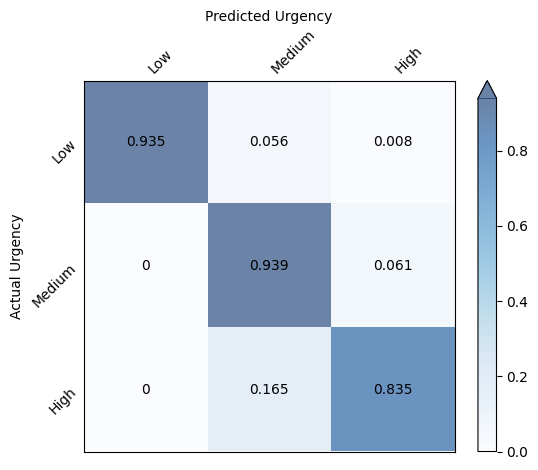

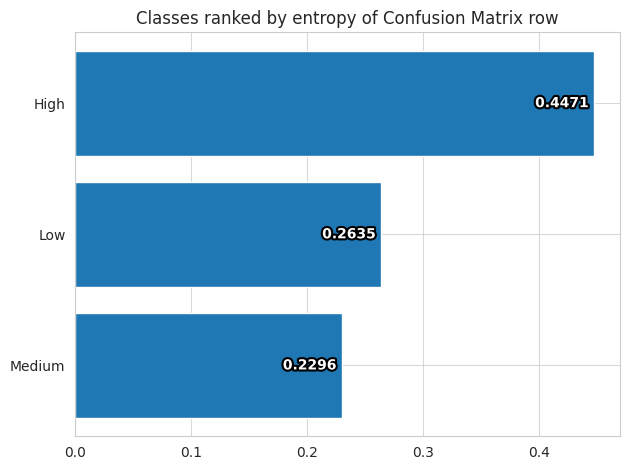

In [ ]:

from ludwig.visualize import confusion_matrix

confusion_matrix(
  [test_stats],
  model.training_set_metadata,
  'type_line',
  top_n_classes=[5],
  model_names=[''],
  normalize=True,
)